In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
# pltのlabelで日本語を使うために必要なモジュールをインポート
import japanize_matplotlib
from matplotlib import rc
from matplotlib.font_manager import FontProperties
from scipy.stats import norm
from scipy.linalg import expm
from math import factorial


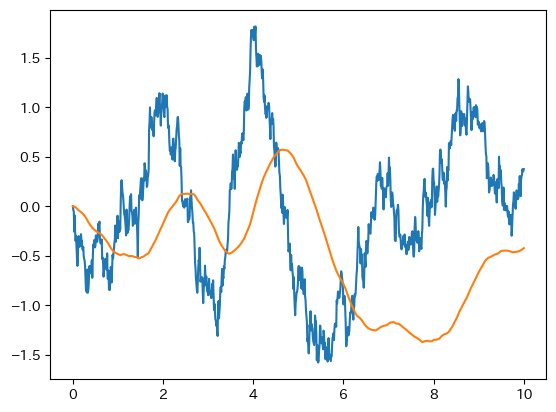

In [3]:
import numpy as np
from scipy.linalg import expm
from scipy.stats import norm

def matrix_exponential(A, t):
    # 固有値と固有ベクトルを計算
    eigenvalues, eigenvectors = np.linalg.eig(A)

    # 固有値の指数行列を作成
    eigenvalues_matrix = np.exp(np.outer(t, eigenvalues))
    # 固有ベクトル行列とその逆行列を計算
    eigenvectors_inv = np.linalg.inv(eigenvectors)
    
    # exp(tA) を計算
    exp_tA = np.einsum('ij,kjl->kil', eigenvectors, eigenvalues_matrix[:, :, np.newaxis] * eigenvectors_inv)
    
    # 実数部分のみを返す
    return np.real(exp_tA)

def linear_Z(theta, t_max, dt, seed):

    np.random.seed(seed)

    theta1 = theta[0]
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]

    A = np.array([[-theta21, -theta22], [theta3, 0]])
    N = int(t_max / dt)  # ステップ数
    times = np.linspace(0, t_max, N + 1)  # 時間グリッド
    
    # ブラウン運動の増分を生成
    dW = norm.rvs(scale=np.sqrt(dt), size=N)
    
    # 全ての時間に対する行列指数関数を計算
    exp_A_t = matrix_exponential(A, times)
    exp_neg_A_t = matrix_exponential(-A, times[:-1])

    # 積分の計算をベクトル化
    theta_vec = np.array([theta1, 0])
    integrand = np.einsum('ijk,k->ij', exp_neg_A_t, theta_vec) * dW[:,np.newaxis]
    cumulative_integral = np.cumsum(integrand, axis=0)
    
    # 形状を合わせるために初めにゼロベクトルを追加
    cumulative_integral = np.vstack((np.zeros((1, A.shape[0])), cumulative_integral))
    
    # Z_t をループなしで計算
    Z_t = np.einsum('ijk,ik->ij', exp_A_t, cumulative_integral)
    
    return Z_t

# 使用例
theta = [1,1,1,1]  
t_max = 10.0  # 最大時間の例
dt = 0.01  # タイムステップの例
seed = 0  # ランダムシードの例

Z_t = linear_Z([1,1,1,1], t_max, dt, 2)
# Z_tの形を(N+1, 2)に変更
Z_t = Z_t.T
plt.plot(np.linspace(0, t_max, int(t_max/dt)+1),Z_t[0])
plt.plot(np.linspace(0, t_max, int(t_max/dt)+1),Z_t[1])

In [16]:
def compute_a(theta,k0):
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    a0 = 1
    a1 = -theta21
    A0 = np.array([[0,1],[-theta22*theta3,-theta21]])
    An = np.array([np.linalg.matrix_power(A0,n) for n in np.arange(k0+1)])
    x0 = np.array([a0,a1])
    xn = np.einsum('ijk,k->ij',An,x0)
    return xn[:,0]

In [46]:
def compute_s(theta, k0):
    theta1 = theta[0]
    theta3 = theta[3]
    
    a = compute_a(theta, k0)
    
    m = np.arange(k0 + 1)
    k = np.arange(k0 + 1)
    
    m_grid, k_grid = np.meshgrid(m, k, indexing='ij')
    
    l_grid = m_grid - k_grid
    valid_mask = (l_grid >= 0) & (k_grid <= k0)
    
    comb_m_k = scipy.special.comb(m_grid, k_grid) * valid_mask
    comb_m1_k = scipy.special.comb(m_grid + 1, k_grid) * valid_mask
    comb_m2_k1 = scipy.special.comb(m_grid + 2, k_grid + 1) * valid_mask
    
    a_k = a[k_grid] * valid_mask
    a_l = np.where(valid_mask, a[l_grid], 0)
    
    fact_m1 = scipy.special.factorial(m_grid + 1)
    fact_m2 = scipy.special.factorial(m_grid + 2)
    fact_m3 = scipy.special.factorial(m_grid + 3)
    
    mat11 = np.sum(theta1**2 * comb_m_k * (1 / fact_m1) * a_k * a_l, axis=1)
    mat12 = np.sum(theta1**2 * theta3 * comb_m1_k * (1 / fact_m2) * a_k * a_l, axis=1)
    mat22 = np.sum(theta3**2 * theta1**2 * comb_m2_k1 * (1 / fact_m3) * a_k * a_l, axis=1)
    
    s = np.zeros((k0 + 1, 2, 2))
    s[:, 0, 0] = mat11
    s[:, 0, 1] = mat12
    s[:, 1, 0] = mat12
    s[:, 1, 1] = mat22
    
    return s

# Test the function
print(compute_s([1, 1, 1, 1], 3))

[[[ 1.          0.5       ]
  [ 0.5         0.33333333]]

 [[-1.         -0.5       ]
  [-0.5        -0.25      ]]

 [[ 0.33333333  0.125     ]
  [ 0.125       0.05      ]]

 [[ 0.08333333  0.04166667]
  [ 0.04166667  0.01388889]]]


In [82]:
import numpy as np
import scipy.special

def calculate_d_e(s):
    k0 = np.shape(s)[0] - 1  # k0を変更
    d = np.zeros_like(s)
    e = np.zeros(k0 + 1)
    
    d[0] = np.linalg.inv(s[0])
    
    for k in range(1, k0 + 1):
        p_idx, q_idx ,r_idx= np.meshgrid(np.arange(k), np.arange(k),np.arange(k), indexing='ij')
        valid_indices = (p_idx+q_idx+r_idx == k-1)
        factorial_k = scipy.special.factorial(k -1)
        
        p_valid = p_idx[valid_indices]
        q_valid = q_idx[valid_indices]
        r_valid = r_idx[valid_indices]
        
        comb_factor = factorial_k / (scipy.special.factorial(p_valid) * scipy.special.factorial(q_valid) * scipy.special.factorial(r_valid))
        
        d[k] =  np.einsum('n,nij,njk,nkl->il', comb_factor,d[p_valid], s[q_valid + 1], d[r_valid])
    
    e[0] = np.log(np.linalg.det(s[0]))
    
    for k in range(1, k0 + 1):
        p_idx, q_idx = np.meshgrid(np.arange(k),np.arange(k),indexing = 'ij')
        valid_indices = (p_idx+q_idx == k-1)
        p_valid = p_idx[valid_indices]
        q_valid = q_idx[valid_indices]
        
        comb_factor = scipy.special.factorial(k) / scipy.special.factorial(p_valid)
        e[k] = -np.einsum('n,nij,nij->', comb_factor, d[p_valid + 1], s[q_valid])
        
    return d, e
calculate_d_e(compute_s([1, 1, 1, 1], 3))

(array([[[ 4.        , -6.        ],
         [-6.        , 12.        ]],
 
        [[-1.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[ 3.13333333, -1.1       ],
         [-1.1       ,  1.2       ]],
 
        [[-9.66666667,  2.        ],
         [ 2.        , -1.        ]]]),
 array([-2.48490665,  1.        , -6.86666667, 40.        ]))

In [8]:
def D(a,x,y,x_,y_,theta1, theta21,theta22, theta3, k0,h):
    def f(x_,y_):
        f = 0
        for k in range(1,k0+1):
            f += (a[k] * x_   - theta22 * a[k-1] *y_) * h**k/np.math.factorial(k)
        return f
    def g(x_,y_):
        g = 0
        for k in range(1,k0+2):
            g += theta3*(a[k-1] * x_   - theta22 * a[k-2] *y_) * h**k/np.math.factorial(k)
        return g
    Dx = h**(-1/2) *(x - x_ - f(x_,y_))
    Dy = h**(-3/2) *(y - y_ - g(x_,y_))
    return np.array([Dx,Dy])

In [9]:
def QL(X,Y,theta1,theta21,theta22,theta3,k0,h):
    a = compute_a(theta1,theta21,theta22,theta3,k0)
    s = compute_s(a,theta1,theta21,theta22,theta3,k0)
    d, e = calculate_d_e(s)
    Q = 0
    for i in range(1,len(X)):
        for k in range(0,k0+1):
            D_ = D(a,X[i],Y[i],X[i-1],Y[i-1],theta1,theta21,theta22,theta3,k0,h)
            Q += - h**k *( np.trace(d[k]@np.outer(D_,D_)) + e[k])
    return Q

In [68]:
h = 0.01
X = Z_t[0,::int(h/dt)]
Y = Z_t[1,::int(h/dt)]

In [69]:
def mokutekikannsuu(theta):
    theta1 = theta[0]
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    k0 = 4
    h = dt
    return -QL(X,Y,theta1,theta21,theta22,theta3,k0,h)

In [70]:
bounds = scipy.optimize.Bounds([0.1,0.1,0.1,0.1],[2,2,2,2])
scipy.optimize.minimize(mokutekikannsuu,[0.5,0.5,0.5,0.5],bounds = bounds,method = 'L-BFGS-B')

      fun: 921.4308258012328
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.54747354e-05,  5.78006621e-01, -1.93267625e-04, -8.41282595e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 220
      nit: 32
     njev: 44
   status: 0
  success: True
        x: array([1.42350982, 0.1       , 1.06778404, 0.99641414])

In [66]:
mokutekikannsuu([1,1,1,1])

1558.8515167835683

In [75]:
import numpy as np
import scipy.special

def compute_a(theta1, theta21, theta22, theta3, k0):
    a = np.zeros(k0 + 1)
    a[0] = 1
    a[1] = -theta21
    for k in range(2, k0 + 1):
        a[k] = -theta21 * a[k-1] - theta22 * theta3 * a[k-2]
    return a

def compute_s(a, theta1, theta21, theta22, theta3, k0):
    s = np.zeros((k0 + 1, 2, 2))
    theta_sq = theta1**2
    theta_cube = theta1**2 * theta3
    
    for m in range(k0 + 1):
        mat11 = 0
        mat12 = 0
        mat22 = 0
        for k in range(min(m+1, k0)):
            l = m - k
            
            comb_mk = scipy.special.comb(m, k)
            comb_m1k = scipy.special.comb(m+1, k)
            comb_m2k1 = scipy.special.comb(m+2, k+1)
            
            # 1,1成分の計算
            mat11 += theta_sq * comb_mk * a[k] * a[l] / np.math.factorial(m+1) 
            
            # 1,2成分の計算
            mat12 += theta_cube * comb_m1k * a[k] * a[l] / np.math.factorial(m+2)
            
            # 2,2成分の計算
            mat22 += theta_sq * theta3**2 * comb_m2k1 * a[k] * a[l] / np.math.factorial(m+3)
        
        s[m] = np.array([[mat11, mat12], [mat12, mat22]])
    
    return s

# Example usage:
theta1 = 0.5
theta21 = 0.3
theta22 = 0.2
theta3 = 0.4
k0 = 10

a = compute_a(theta1, theta21, theta22, theta3, k0)
s = compute_s(a, theta1, theta21, theta22, theta3, k0)

print(s[10])


[[-1.32708740e-11 -8.78760906e-13]
 [-8.78760906e-13 -5.43236380e-14]]
